In [27]:
import os
import cv2
import pandas as pd

import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [28]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPool2D 
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import layers, Model

In [29]:
X_train_tmp_folder_path = r"C:\Users\shrir\OneDrive\Desktop\GAN\GAN_PS\CCGAN\mat_ccgan\disc_temp_mat\572"
X_train_dsp_folder_path = r"C:\Users\shrir\OneDrive\Desktop\GAN\GAN_PS\CCGAN\mat_ccgan\disc_disp_mat\572"
Y_train_folder_path = r"C:\Users\shrir\OneDrive\Desktop\GAN\GAN_PS\resized\upscale\388"

In [30]:
X_train_tmp_elements = os.listdir(X_train_tmp_folder_path) 
X_train_dsp_elements = os.listdir(X_train_dsp_folder_path) 
Y_train_elements = os.listdir(Y_train_folder_path)

In [31]:
X_train = np.zeros((20,572,572,2))
Y_train = np.zeros((20,388,388,1))

In [32]:
# DEVELOPING X_train MATRIX

for index, (tmp_element, dsp_element) in enumerate(zip(X_train_tmp_elements, X_train_dsp_elements)):
    # Load images for each channel
    tmp_element_path = os.path.join(X_train_tmp_folder_path, tmp_element)
    dsp_element_path = os.path.join(X_train_dsp_folder_path, dsp_element)
    img_tmp = imread(tmp_element_path)
    img_dsp = imread(dsp_element_path)
    
    # Reshape images for each channel
    img_tmp = img_tmp.reshape((572,572, 1))
    img_dsp = img_dsp.reshape((572,572, 1))
    
    # Combine channels
    img_combined = np.concatenate((img_tmp, img_dsp), axis=2)
    
    # Assign to X_train
    X_train[index] = img_combined

In [33]:

X_train.shape

(20, 572, 572, 2)

In [34]:
X_train[0]

array([[[1., 1.],
        [1., 1.],
        [1., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       ...,

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]])

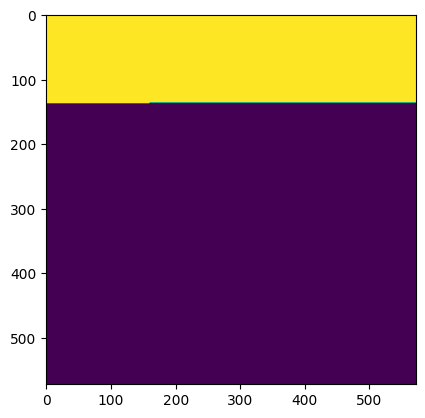

In [35]:
plt.imshow(X_train[5][:,:,1])

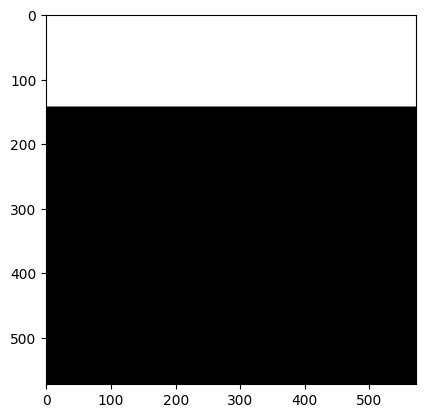

In [36]:
plt.imshow(X_train[0][:,:,0],cmap='gray')


In [37]:
# DEVELOPING Y_train MATRIX
for index,Y_train_element in enumerate(Y_train_elements):
    element_path = os.path.join(Y_train_folder_path, Y_train_element)
    img = imread(element_path)
    
    img = np.mean(img, axis=2)
    img = img/255
    img = img.reshape((388, 388, 1))
    Y_train[index] = img

In [38]:
Y_train[0]

array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]])

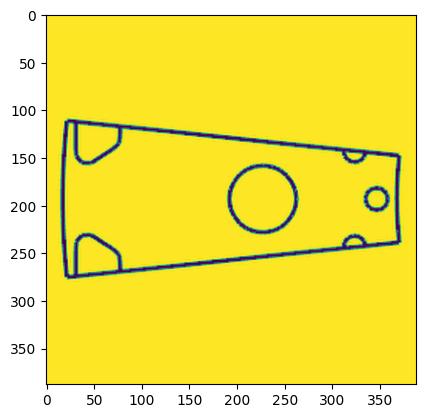

In [39]:
plt.imshow(Y_train[15])

In [40]:
Y_train.shape

(20, 388, 388, 1)

In [41]:
def crop_and_concat(up_layer, down_layer):
    down_layer_shape = tf.shape(down_layer)
    up_layer_shape = tf.shape(up_layer)
    offsets = [0, (down_layer_shape[1] - up_layer_shape[1]) // 2, (down_layer_shape[2] - up_layer_shape[2]) // 2, 0]
    size = [-1, up_layer_shape[1], up_layer_shape[2], -1]
    down_layer_cropped = tf.slice(down_layer, offsets, size)
    return tf.concat([down_layer_cropped, up_layer], axis=-1)


def unet_sequential(input_size=(572, 572, 2)):
    model = Sequential()

    # Contracting path
    model.add(layers.Input(shape=input_size))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    c1 = model.layers[-1].output
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    c2 = model.layers[-1].output
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    c3 = model.layers[-1].output
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    c4 = model.layers[-1].output
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    c5 = model.layers[-1].output

    # Expansive path
    model.add(layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same'))
    #model.add(layers.Lambda(lambda x: crop_and_concat(x, c4)))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal'))

    model.add(layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same'))
    #model.add(layers.Lambda(lambda x: crop_and_concat(x, c3)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal'))

    model.add(layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same'))
    #model.add(layers.Lambda(lambda x: crop_and_concat(x, c2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal'))

    model.add(layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same'))
    #model.add(layers.Lambda(lambda x: crop_and_concat(x, c1)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))

    model.add(layers.Conv2D(1, (1, 1), activation='sigmoid'))

    return model

# Example usage
model = unet_sequential(input_size=(572, 572, 2))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 570, 570, 64)      1216      
                                                                 
 batch_normalization_10 (Bat  (None, 570, 570, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_20 (Conv2D)          (None, 568, 568, 64)      36928     
                                                                 
 batch_normalization_11 (Bat  (None, 568, 568, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 284, 284, 64)     0         
 2D)                                                             
                                                      

In [43]:
#model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [44]:
#model.fit(X_train,Y_train,epochs = 10, batch_size=2)

In [18]:
#model.fit(X_train, Y_train, epochs=10, batch_size=2, callbacks=[PlotPredictions()])

In [ ]:
#@tf.function
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(10000).batch(1) 

# gradient accumulation
accumulation_steps = 4  # Number of mini-batches to accumulate before updating weights
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
epochs = 10
#loss_fn = tf.keras.losses.MeanSquaredError()
loss_fn = tf.keras.losses.BinaryCrossentropy()

def train_step(inputs, targets, accum_gradients, first_batch):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    
    if first_batch:
        accum_gradients = gradients
    else:
        accum_gradients = [accum_grad + grad for accum_grad, grad in zip(accum_gradients, gradients)]
    
    return accum_gradients, loss

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    accum_gradients = None
    for step, (x_batch, y_batch) in enumerate(train_dataset):
        first_batch = (step % accumulation_steps == 0)
        accum_gradients, loss = train_step(x_batch, y_batch, accum_gradients, first_batch)
        
        if (step + 1) % accumulation_steps == 0:
            optimizer.apply_gradients(zip(accum_gradients, model.trainable_variables))
            accum_gradients = None
        print(f"Step {step+1}, Loss: {loss.numpy()}")


    if accum_gradients is not None:
        optimizer.apply_gradients(zip(accum_gradients, model.trainable_variables))

In [ ]:
model.save("UNET_PAPER_100epochs.h5")

In [46]:
pred_in_com_1_tmp_path = r"C:\Users\shrir\OneDrive\Desktop\GAN\GAN_PS\CCGAN\mat_ccgan\disc_temp_mat\572\cc_572_temp_cv_273_in.png"
pred_in_com_1_dsp_path = r"C:\Users\shrir\OneDrive\Desktop\GAN\GAN_PS\CCGAN\mat_ccgan\disc_disp_mat\572\cc_572_disp_cv_273_in.png"
pred_in_com_1_tmp = imread(pred_in_com_1_tmp_path)
pred_in_com_1_dsp = imread(pred_in_com_1_dsp_path)

pred_in_com_1_tmp = pred_in_com_1_tmp.reshape((572, 572, 1))
pred_in_com_1_dsp = pred_in_com_1_dsp.reshape((572, 572, 1))

pred_in_com_1 = np.concatenate((pred_in_com_1_tmp, pred_in_com_1_dsp), axis=2)

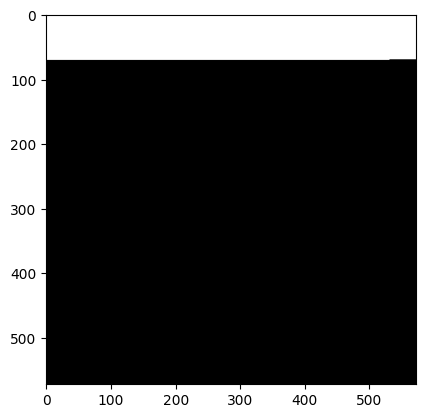

In [47]:
plt.imshow(pred_in_com_1_tmp, cmap = 'gray')

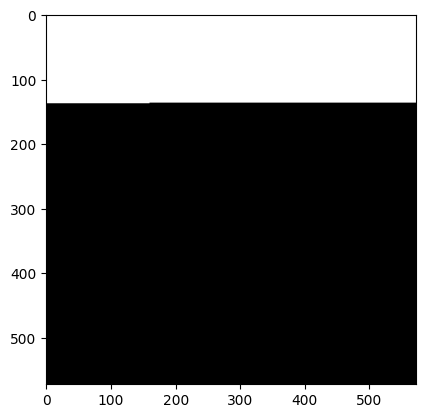

In [48]:
plt.imshow(pred_in_com_1_dsp, cmap = 'gray')

In [ ]:
pred_in_com_1 = pred_in_com_1.reshape((1,572,572,2))

pred_out_com_1 = model.predict(pred_in_com_1)

pred_out_com_1 = pred_out_com_1.reshape((388, 388))

plt.imshow(pred_out_com_1, cmap = 'gray')

In [62]:
img = model(tf.expand_dims(X_train[5],axis=0))

In [65]:


# If you prefer using array slicing directly:
img_array = img[0, :, :, 0]  # Extract the inner 2D array
print(img_array.shape)  # Should print (388, 388)

(388, 388)


In [66]:
img_array

<tf.Tensor: shape=(388, 388), dtype=float32, numpy=
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>

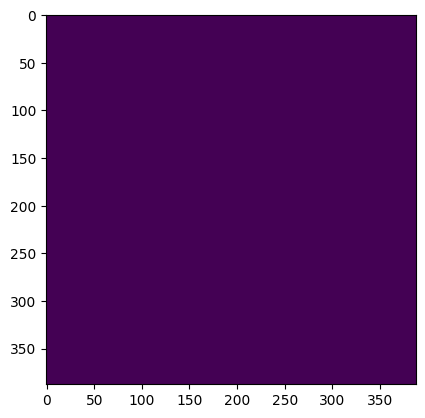

In [69]:
img_array*=255
plt.imshow(img_array,cmap='gray')

In [68]:
img_array

<tf.Tensor: shape=(388, 388), dtype=float32, numpy=
array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]], dtype=float32)>

In [61]:
plt.imshow(img.reshape(388,388))

AttributeError: EagerTensor object has no attribute 'reshape'. 
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()
      

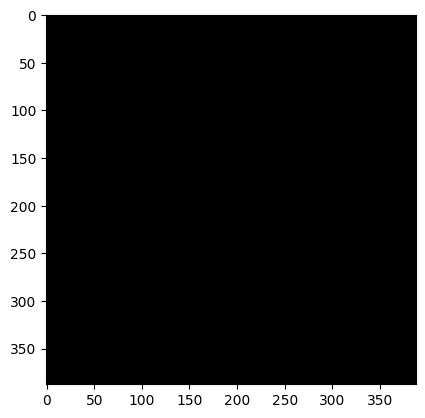

In [40]:
plt.imshow(img[0],cmap='gray')

In [42]:
Y_train[0].shape

(388, 388, 1)

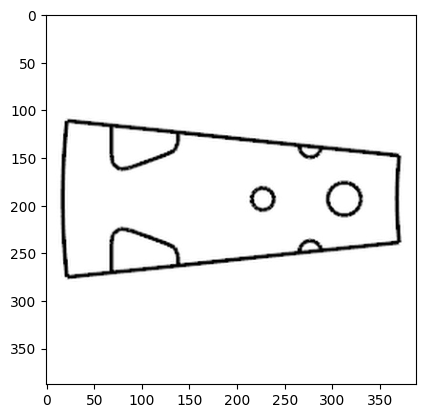

In [44]:
plt.imshow(Y_train[5].reshape(388,388),cmap='gray')